In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq, kmeans

from qqdm import qqdm, format_str
import pandas as pd
import os,glob,imageio
import pdb  # use pdb.set_trace() to set breakpoints for debugging




In [2]:
base_path = r'.'
base_path = r'C:\Users\alwaysmle\Desktop\pytorch\histology-images-query-competition'
query_csv = os.path.join(base_path,  'queries.csv')
train_dir = os.path.join(base_path,  'train', 'train')
test_dir = os.path.join(base_path,  'test', 'test')
combine_dir = os.path.join(base_path,  'combine')

In [3]:
test_names = glob.glob(os.path.join(test_dir, '*') )
test_numpy = []
test_name = []
for image_path in test_names:
  id_name = image_path[-16:-4]
  im = imageio.imread(image_path)
  test_numpy.append(im)
  test_name.append(id_name)
  print(len(test_numpy))
train_numpy = np.array(test_numpy)
np.save('test',test_numpy)
np.save('test_id',tesn_name)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [ ]:
test_names = glob.glob(os.path.join(test_dir, '*') )
test_numpy = []
for image_path in test_names:
  im = imageio.imread(image_path)
  test_numpy.append(im)
  print(len(test_numpy))
train_numpy = np.array(test_numpy)
np.save('test',test_numpy)

# Loading data

In [3]:
train = np.load('train.npy', allow_pickle=True)
test = np.load('test.npy', allow_pickle=True)
test_id = np.load('test_id.npy', allow_pickle=True)
combine = np.append(train,test,axis = 0)
print(train.shape)
print(test.shape)
print(combine.shape)

(6187, 256, 256, 3)
(3427, 256, 256, 3)
(9614, 256, 256, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [4]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

# Autoencoder

# Models & loss

Lecture video：https://www.youtube.com/watch?v=6W8FqUGYyDo&list=PLJV_el3uVTsOK_ZK5L0Iv_EQoL1JefRL4&index=8

fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner

conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/

In [5]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 64 * 64 * 3), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# maybe it can be smaller
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        start_dim = 2
        self.encoder = nn.Sequential(
            nn.Conv2d(3, start_dim, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.Conv2d(start_dim, start_dim*2, 4, stride=2, padding=1),        
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.Conv2d(start_dim*2, start_dim*4, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.Conv2d(start_dim*4, start_dim*8, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.Conv2d(start_dim*8, start_dim*16, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*16),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(start_dim*16, start_dim*8, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.ConvTranspose2d(start_dim*8, start_dim*4, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.ConvTranspose2d(start_dim*4, start_dim*2, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.ConvTranspose2d(start_dim*2, start_dim, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.ConvTranspose2d(start_dim, 3, 4, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(3),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD


class Resnet(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(Resnet, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)

        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        if x.shape[0] > 1:
            x = self.bn1(self.fc1(x))
        else:
            x = self.fc1(x)
        x = self.relu(x)
        if x.shape[0] > 1:
            x = self.bn2(self.fc2(x))
        else:
            x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3_mu(x)
        return x

    def decode(self, z):
        if z.shape[0] > 1:
            x = self.relu(self.fc_bn4(self.fc4(z)))
            x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        else:
            x = self.relu(self.fc4(z))
            x = self.relu(self.fc5(x)).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=True)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_reconst = self.decode(z)

        return x_reconst


# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [6]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
                            transforms.Lambda(lambda x: x.to(torch.float32)),
                            transforms.Lambda(lambda x: 2. * x/255. - 1.),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return index,x

    def __len__(self):
        return len(self.tensors)

# Training

## Initialize
- hyperparameters
- dataloader
- model
- optimizer & loss


In [7]:
# Training hyperparameters
num_epochs = 500
batch_size = 130 # medium: smaller batchsize
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(combine)
train_dataset = CustomTensorDataset(x)
test_data =  torch.from_numpy(test)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)


test_dataset = CustomTensorDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=300)

# Model
model_type = 'cnn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = { 'cnn':conv_autoencoder() }
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

In [8]:
from torchsummary import summary
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 2, 128, 128]              98
              ReLU-2          [-1, 2, 128, 128]               0
       BatchNorm2d-3          [-1, 2, 128, 128]               4
            Conv2d-4            [-1, 4, 64, 64]             132
              ReLU-5            [-1, 4, 64, 64]               0
       BatchNorm2d-6            [-1, 4, 64, 64]               8
            Conv2d-7            [-1, 8, 32, 32]             520
              ReLU-8            [-1, 8, 32, 32]               0
       BatchNorm2d-9            [-1, 8, 32, 32]              16
           Conv2d-10           [-1, 16, 16, 16]           2,064
             ReLU-11           [-1, 16, 16, 16]               0
      BatchNorm2d-12           [-1, 16, 16, 16]              32
           Conv2d-13             [-1, 32, 8, 8]           8,224
             ReLU-14             [-1, 3

## Training loop

In [9]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for index,data in train_dataloader:
        #print(data)
        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model2_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model2_{}.pt'.format(model_type))




 Iters    Elapsed Time      Speed                                                                                       
 0/500          -             -                                                                                         
Description   0.0% |                                                                                                   | Iters    Elapsed Time      Speed    epoch   loss                                                                       
 1/500  00:00:08<01:12:47  0.11it/s  1/500  0.8390                                                                      
Description   0.2% |                                                                                                   | Iters    Elapsed Time      Speed    epoch   loss                                                                       
 2/500  00:00:16<01:10:17  0.12it/s  2/500  0.5082                                                                      
Description   0.4% |              

Description   3.2% |███                                                                                                | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 17/500  00:02:24<01:08:15  0.12it/s  17/500  0.0362                                                                    
Description   3.4% |███                                                                                                | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 18/500  00:02:32<01:08:08  0.12it/s  18/500  0.0355                                                                    
Description   3.6% |███                                                                                                | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 19/500  00:02:41<01:07:59  0.12it/

Description   6.4% |██████                                                                                             | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 33/500  00:04:39<01:06:00  0.12it/s  33/500  0.0310                                                                    
Description   6.6% |██████                                                                                             | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 34/500  00:04:48<01:05:51  0.12it/s  34/500  0.0307                                                                    
Description   6.8% |██████                                                                                             | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 35/500  00:04:56<01:05:43  0.12it/

Description   9.4% |█████████                                                                                          | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 48/500  00:06:46<01:03:50  0.12it/s  48/500  0.0286                                                                    
Description   9.6% |█████████                                                                                          | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 49/500  00:06:55<01:03:42  0.12it/s  49/500  0.0285                                                                    
Description   9.8% |█████████                                                                                          | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 50/500  00:07:03<01:03:33  0.12it/

Description  12.2% |████████████                                                                                       | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 62/500  00:08:45<01:01:51  0.12it/s  62/500  0.0273                                                                    
Description  12.4% |████████████                                                                                       | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 63/500  00:08:53<01:01:43  0.12it/s  63/500  0.0274                                                                    
Description  12.6% |████████████                                                                                       | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 64/500  00:09:02<01:01:34  0.12it/

Description  15.0% |██████████████                                                                                     | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 76/500  00:10:43<00:59:51  0.12it/s  76/500  0.0265                                                                    
Description  15.2% |███████████████                                                                                    | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 77/500  00:10:52<00:59:42  0.12it/s  77/500  0.0280                                                                    
Description  15.4% |███████████████                                                                                    | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 78/500  00:11:00<00:59:34  0.12it/

Description  17.6% |█████████████████                                                                                  | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 89/500  00:12:33<00:57:59  0.12it/s  89/500  0.0260                                                                    
Description  17.8% |█████████████████                                                                                  | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 90/500  00:12:41<00:57:50  0.12it/s  90/500  0.0260                                                                    
Description  18.0% |█████████████████                                                                                  | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 91/500  00:12:50<00:57:42  0.12it/

Description  20.2% |███████████████████                                                                                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 102/500  00:14:23<00:56:08  0.12it/s  102/500  0.0250                                                                  
Description  20.4% |████████████████████                                                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 103/500  00:14:31<00:56:00  0.12it/s  103/500  0.0250                                                                  
Description  20.6% |████████████████████                                                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 104/500  00:14:40<00:55:51  0.12it

Description  22.6% |██████████████████████                                                                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 114/500  00:16:04<00:54:25  0.12it/s  114/500  0.0253                                                                  
Description  22.8% |██████████████████████                                                                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 115/500  00:16:12<00:54:17  0.12it/s  115/500  0.0246                                                                  
Description  23.0% |██████████████████████                                                                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 116/500  00:16:21<00:54:08  0.12it

Description  25.0% |████████████████████████                                                                           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 126/500  00:17:44<00:52:41  0.12it/s  126/500  0.0242                                                                  
Description  25.2% |████████████████████████                                                                           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 127/500  00:17:53<00:52:32  0.12it/s  127/500  0.0240                                                                  
Description  25.4% |█████████████████████████                                                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 128/500  00:18:01<00:52:23  0.12it

Description  27.4% |███████████████████████████                                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 138/500  00:19:25<00:50:56  0.12it/s  138/500  0.0238                                                                  
Description  27.6% |███████████████████████████                                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 139/500  00:19:33<00:50:48  0.12it/s  139/500  0.0239                                                                  
Description  27.8% |███████████████████████████                                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 140/500  00:19:42<00:50:39  0.12it

Description  29.6% |█████████████████████████████                                                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 149/500  00:20:57<00:49:21  0.12it/s  149/500  0.0235                                                                  
Description  29.8% |█████████████████████████████                                                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 150/500  00:21:05<00:49:13  0.12it/s  150/500  0.0235                                                                  
Description  30.0% |█████████████████████████████                                                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 151/500  00:21:14<00:49:04  0.12it

Description  31.8% |███████████████████████████████                                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 160/500  00:22:29<00:47:47  0.12it/s  160/500  0.0233                                                                  
Description  32.0% |███████████████████████████████                                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 161/500  00:22:37<00:47:38  0.12it/s  161/500  0.0233                                                                  
Description  32.2% |███████████████████████████████                                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 162/500  00:22:46<00:47:30  0.12it

Description  34.0% |█████████████████████████████████                                                                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 171/500  00:24:01<00:46:13  0.12it/s  171/500  0.0227                                                                  
Description  34.2% |█████████████████████████████████                                                                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 172/500  00:24:09<00:46:04  0.12it/s  172/500  0.0228                                                                  
Description  34.4% |██████████████████████████████████                                                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 173/500  00:24:18<00:45:56  0.12it

Description  36.0% |███████████████████████████████████                                                                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 181/500  00:25:25<00:44:47  0.12it/s  181/500  0.0226                                                                  
Description  36.2% |███████████████████████████████████                                                                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 182/500  00:25:33<00:44:39  0.12it/s  182/500  0.0226                                                                  
Description  36.4% |████████████████████████████████████                                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 183/500  00:25:41<00:44:30  0.12it

Description  38.0% |█████████████████████████████████████                                                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 191/500  00:26:48<00:43:22  0.12it/s  191/500  0.0225                                                                  
Description  38.2% |█████████████████████████████████████                                                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 192/500  00:26:57<00:43:14  0.12it/s  192/500  0.0225                                                                  
Description  38.4% |██████████████████████████████████████                                                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 193/500  00:27:05<00:43:05  0.12it

Description  40.0% |███████████████████████████████████████                                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 201/500  00:28:12<00:41:57  0.12it/s  201/500  0.0225                                                                  
Description  40.2% |███████████████████████████████████████                                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 202/500  00:28:20<00:41:49  0.12it/s  202/500  0.0225                                                                  
Description  40.4% |███████████████████████████████████████                                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 203/500  00:28:29<00:41:40  0.12it

Description  42.0% |█████████████████████████████████████████                                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 211/500  00:29:36<00:40:32  0.12it/s  211/500  0.0225                                                                  
Description  42.2% |█████████████████████████████████████████                                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 212/500  00:29:44<00:40:24  0.12it/s  212/500  0.0225                                                                  
Description  42.4% |█████████████████████████████████████████                                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 213/500  00:29:53<00:40:16  0.12it

Description  43.8% |███████████████████████████████████████████                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 220/500  00:30:51<00:39:16  0.12it/s  220/500  0.0225                                                                  
Description  44.0% |███████████████████████████████████████████                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 221/500  00:31:00<00:39:08  0.12it/s  221/500  0.0224                                                                  
Description  44.2% |███████████████████████████████████████████                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 222/500  00:31:08<00:38:59  0.12it

Description  45.6% |█████████████████████████████████████████████                                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 229/500  00:32:07<00:38:00  0.12it/s  229/500  0.0224                                                                  
Description  45.8% |█████████████████████████████████████████████                                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 230/500  00:32:15<00:37:52  0.12it/s  230/500  0.0224                                                                  
Description  46.0% |█████████████████████████████████████████████                                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 231/500  00:32:23<00:37:43  0.12it

Description  47.4% |██████████████████████████████████████████████                                                     |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 238/500  00:33:22<00:36:44  0.12it/s  238/500  0.0224                                                                  
Description  47.6% |███████████████████████████████████████████████                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 239/500  00:33:30<00:36:35  0.12it/s  239/500  0.0223                                                                  
Description  47.8% |███████████████████████████████████████████████                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 240/500  00:33:39<00:36:27  0.12it

Description  49.2% |████████████████████████████████████████████████                                                   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 247/500  00:34:37<00:35:28  0.12it/s  247/500  0.0223                                                                  
Description  49.4% |████████████████████████████████████████████████                                                   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 248/500  00:34:46<00:35:19  0.12it/s  248/500  0.0223                                                                  
Description  49.6% |█████████████████████████████████████████████████                                                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 249/500  00:34:54<00:35:11  0.12it

Description  51.0% |██████████████████████████████████████████████████                                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 256/500  00:35:53<00:34:12  0.12it/s  256/500  0.0224                                                                  
Description  51.2% |██████████████████████████████████████████████████                                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 257/500  00:36:01<00:34:03  0.12it/s  257/500  0.0224                                                                  
Description  51.4% |██████████████████████████████████████████████████                                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 258/500  00:36:10<00:33:55  0.12it

Description  52.8% |████████████████████████████████████████████████████                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 265/500  00:37:08<00:32:56  0.12it/s  265/500  0.0222                                                                  
Description  53.0% |████████████████████████████████████████████████████                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 266/500  00:37:16<00:32:47  0.12it/s  266/500  0.0223                                                                  
Description  53.2% |████████████████████████████████████████████████████                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 267/500  00:37:25<00:32:39  0.12it

Description  54.4% |█████████████████████████████████████████████████████                                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 273/500  00:38:15<00:31:48  0.12it/s  273/500  0.0223                                                                  
Description  54.6% |██████████████████████████████████████████████████████                                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 274/500  00:38:23<00:31:40  0.12it/s  274/500  0.0223                                                                  
Description  54.8% |██████████████████████████████████████████████████████                                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 275/500  00:38:32<00:31:31  0.12it

Description  56.0% |███████████████████████████████████████████████████████                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 281/500  00:39:22<00:30:41  0.12it/s  281/500  0.0223                                                                  
Description  56.2% |███████████████████████████████████████████████████████                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 282/500  00:39:30<00:30:32  0.12it/s  282/500  0.0223                                                                  
Description  56.4% |███████████████████████████████████████████████████████                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 283/500  00:39:39<00:30:24  0.12it

Description  57.6% |█████████████████████████████████████████████████████████                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 289/500  00:40:29<00:29:33  0.12it/s  289/500  0.0222                                                                  
Description  57.8% |█████████████████████████████████████████████████████████                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 290/500  00:40:37<00:29:25  0.12it/s  290/500  0.0222                                                                  
Description  58.0% |█████████████████████████████████████████████████████████                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 291/500  00:40:46<00:29:16  0.12it

Description  59.2% |██████████████████████████████████████████████████████████                                         |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 297/500  00:41:36<00:28:26  0.12it/s  297/500  0.0222                                                                  
Description  59.4% |██████████████████████████████████████████████████████████                                         |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 298/500  00:41:44<00:28:17  0.12it/s  298/500  0.0222                                                                  
Description  59.6% |███████████████████████████████████████████████████████████                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 299/500  00:41:53<00:28:09  0.12it

Description  60.8% |████████████████████████████████████████████████████████████                                       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 305/500  00:42:43<00:27:18  0.12it/s  305/500  0.0222                                                                  
Description  61.0% |████████████████████████████████████████████████████████████                                       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 306/500  00:42:51<00:27:10  0.12it/s  306/500  0.0223                                                                  
Description  61.2% |████████████████████████████████████████████████████████████                                       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 307/500  00:43:00<00:27:02  0.12it

Description  62.4% |█████████████████████████████████████████████████████████████                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 313/500  00:43:50<00:26:11  0.12it/s  313/500  0.0223                                                                  
Description  62.6% |█████████████████████████████████████████████████████████████                                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 314/500  00:43:58<00:26:03  0.12it/s  314/500  0.0222                                                                  
Description  62.8% |██████████████████████████████████████████████████████████████                                     |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 315/500  00:44:07<00:25:54  0.12it

Description  64.0% |███████████████████████████████████████████████████████████████                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 321/500  00:44:57<00:25:04  0.12it/s  321/500  0.0223                                                                  
Description  64.2% |███████████████████████████████████████████████████████████████                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 322/500  00:45:05<00:24:55  0.12it/s  322/500  0.0223                                                                  
Description  64.4% |███████████████████████████████████████████████████████████████                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 323/500  00:45:14<00:24:47  0.12it

Description  65.6% |████████████████████████████████████████████████████████████████                                   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 329/500  00:46:04<00:23:56  0.12it/s  329/500  0.0222                                                                  
Description  65.8% |█████████████████████████████████████████████████████████████████                                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 330/500  00:46:12<00:23:48  0.12it/s  330/500  0.0223                                                                  
Description  66.0% |█████████████████████████████████████████████████████████████████                                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 331/500  00:46:21<00:23:39  0.12it

Description  67.0% |██████████████████████████████████████████████████████████████████                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 336/500  00:47:03<00:22:57  0.12it/s  336/500  0.0222                                                                  
Description  67.2% |██████████████████████████████████████████████████████████████████                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 337/500  00:47:11<00:22:49  0.12it/s  337/500  0.0222                                                                  
Description  67.4% |██████████████████████████████████████████████████████████████████                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 338/500  00:47:19<00:22:41  0.12it

Description  68.4% |███████████████████████████████████████████████████████████████████                                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 343/500  00:48:01<00:21:59  0.12it/s  343/500  0.0221                                                                  
Description  68.6% |███████████████████████████████████████████████████████████████████                                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 344/500  00:48:10<00:21:50  0.12it/s  344/500  0.0222                                                                  
Description  68.8% |████████████████████████████████████████████████████████████████████                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 345/500  00:48:18<00:21:42  0.12it

Description  69.8% |█████████████████████████████████████████████████████████████████████                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 350/500  00:49:00<00:21:00  0.12it/s  350/500  0.0222                                                                  
Description  70.0% |█████████████████████████████████████████████████████████████████████                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 351/500  00:49:08<00:20:51  0.12it/s  351/500  0.0222                                                                  
Description  70.2% |█████████████████████████████████████████████████████████████████████                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 352/500  00:49:17<00:20:43  0.12it

Description  71.2% |██████████████████████████████████████████████████████████████████████                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 357/500  00:49:59<00:20:01  0.12it/s  357/500  0.0221                                                                  
Description  71.4% |██████████████████████████████████████████████████████████████████████                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 358/500  00:50:07<00:19:52  0.12it/s  358/500  0.0222                                                                  
Description  71.6% |██████████████████████████████████████████████████████████████████████                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 359/500  00:50:15<00:19:44  0.12it

Description  72.6% |███████████████████████████████████████████████████████████████████████                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 364/500  00:50:57<00:19:02  0.12it/s  364/500  0.0222                                                                  
Description  72.8% |████████████████████████████████████████████████████████████████████████                           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 365/500  00:51:06<00:18:54  0.12it/s  365/500  0.0222                                                                  
Description  73.0% |████████████████████████████████████████████████████████████████████████                           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 366/500  00:51:14<00:18:45  0.12it

Description  74.0% |█████████████████████████████████████████████████████████████████████████                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 371/500  00:51:56<00:18:03  0.12it/s  371/500  0.0223                                                                  
Description  74.2% |█████████████████████████████████████████████████████████████████████████                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 372/500  00:52:04<00:17:55  0.12it/s  372/500  0.0221                                                                  
Description  74.4% |█████████████████████████████████████████████████████████████████████████                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 373/500  00:52:13<00:17:46  0.12it

Description  75.4% |██████████████████████████████████████████████████████████████████████████                         |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 378/500  00:52:54<00:17:04  0.12it/s  378/500  0.0222                                                                  
Description  75.6% |██████████████████████████████████████████████████████████████████████████                         |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 379/500  00:53:03<00:16:56  0.12it/s  379/500  0.0222                                                                  
Description  75.8% |███████████████████████████████████████████████████████████████████████████                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 380/500  00:53:11<00:16:47  0.12it

Description  76.8% |████████████████████████████████████████████████████████████████████████████                       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 385/500  00:53:53<00:16:05  0.12it/s  385/500  0.0222                                                                  
Description  77.0% |████████████████████████████████████████████████████████████████████████████                       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 386/500  00:54:02<00:15:57  0.12it/s  386/500  0.0222                                                                  
Description  77.2% |████████████████████████████████████████████████████████████████████████████                       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 387/500  00:54:10<00:15:49  0.12it

Description  78.2% |█████████████████████████████████████████████████████████████████████████████                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 392/500  00:54:52<00:15:07  0.12it/s  392/500  0.0221                                                                  
Description  78.4% |█████████████████████████████████████████████████████████████████████████████                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 393/500  00:55:01<00:14:58  0.12it/s  393/500  0.0224                                                                  
Description  78.6% |█████████████████████████████████████████████████████████████████████████████                      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 394/500  00:55:09<00:14:50  0.12it

Description  79.6% |██████████████████████████████████████████████████████████████████████████████                     |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 399/500  00:55:51<00:14:08  0.12it/s  399/500  0.0221                                                                  
Description  79.8% |███████████████████████████████████████████████████████████████████████████████                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 400/500  00:55:59<00:13:59  0.12it/s  400/500  0.0223                                                                  
Description  80.0% |███████████████████████████████████████████████████████████████████████████████                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 401/500  00:56:08<00:13:51  0.12it

Description  81.0% |████████████████████████████████████████████████████████████████████████████████                   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 406/500  00:56:50<00:13:09  0.12it/s  406/500  0.0222                                                                  
Description  81.2% |████████████████████████████████████████████████████████████████████████████████                   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 407/500  00:56:58<00:13:01  0.12it/s  407/500  0.0221                                                                  
Description  81.4% |████████████████████████████████████████████████████████████████████████████████                   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 408/500  00:57:06<00:12:52  0.12it

Description  82.4% |█████████████████████████████████████████████████████████████████████████████████                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 413/500  00:57:48<00:12:10  0.12it/s  413/500  0.0223                                                                  
Description  82.6% |█████████████████████████████████████████████████████████████████████████████████                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 414/500  00:57:57<00:12:02  0.12it/s  414/500  0.0222                                                                  
Description  82.8% |█████████████████████████████████████████████████████████████████████████████████                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 415/500  00:58:05<00:11:53  0.12it

Description  83.8% |██████████████████████████████████████████████████████████████████████████████████                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 420/500  00:58:47<00:11:11  0.12it/s  420/500  0.0222                                                                  
Description  84.0% |███████████████████████████████████████████████████████████████████████████████████                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 421/500  00:58:55<00:11:03  0.12it/s  421/500  0.0222                                                                  
Description  84.2% |███████████████████████████████████████████████████████████████████████████████████                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 422/500  00:59:04<00:10:55  0.12it

Description  85.0% |████████████████████████████████████████████████████████████████████████████████████               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 426/500  00:59:37<00:10:21  0.12it/s  426/500  0.0221                                                                  
Description  85.2% |████████████████████████████████████████████████████████████████████████████████████               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 427/500  00:59:45<00:10:13  0.12it/s  427/500  0.0222                                                                  
Description  85.4% |████████████████████████████████████████████████████████████████████████████████████               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 428/500  00:59:54<00:10:04  0.12it

Description  86.2% |█████████████████████████████████████████████████████████████████████████████████████              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 432/500  01:00:27<00:09:31  0.12it/s  432/500  0.0222                                                                  
Description  86.4% |█████████████████████████████████████████████████████████████████████████████████████              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 433/500  01:00:36<00:09:22  0.12it/s  433/500  0.0222                                                                  
Description  86.6% |█████████████████████████████████████████████████████████████████████████████████████              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 434/500  01:00:44<00:09:14  0.12it

Description  87.4% |██████████████████████████████████████████████████████████████████████████████████████             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 438/500  01:01:17<00:08:40  0.12it/s  438/500  0.0223                                                                  
Description  87.6% |██████████████████████████████████████████████████████████████████████████████████████             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 439/500  01:01:26<00:08:32  0.12it/s  439/500  0.0222                                                                  
Description  87.8% |██████████████████████████████████████████████████████████████████████████████████████             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 440/500  01:01:34<00:08:23  0.12it

Description  88.6% |███████████████████████████████████████████████████████████████████████████████████████            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 444/500  01:02:08<00:07:50  0.12it/s  444/500  0.0222                                                                  
Description  88.8% |███████████████████████████████████████████████████████████████████████████████████████            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 445/500  01:02:16<00:07:41  0.12it/s  445/500  0.0222                                                                  
Description  89.0% |████████████████████████████████████████████████████████████████████████████████████████           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 446/500  01:02:24<00:07:33  0.12it

Description  89.8% |████████████████████████████████████████████████████████████████████████████████████████           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 450/500  01:02:58<00:06:59  0.12it/s  450/500  0.0221                                                                  
Description  90.0% |█████████████████████████████████████████████████████████████████████████████████████████          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 451/500  01:03:06<00:06:51  0.12it/s  451/500  0.0221                                                                  
Description  90.2% |█████████████████████████████████████████████████████████████████████████████████████████          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 452/500  01:03:15<00:06:43  0.12it

Description  91.0% |██████████████████████████████████████████████████████████████████████████████████████████         |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 456/500  01:03:48<00:06:09  0.12it/s  456/500  0.0222                                                                  
Description  91.2% |██████████████████████████████████████████████████████████████████████████████████████████         |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 457/500  01:03:57<00:06:01  0.12it/s  457/500  0.0222                                                                  
Description  91.4% |██████████████████████████████████████████████████████████████████████████████████████████         |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 458/500  01:04:05<00:05:52  0.12it

Description  92.2% |███████████████████████████████████████████████████████████████████████████████████████████        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 462/500  01:04:39<00:05:19  0.12it/s  462/500  0.0222                                                                  
Description  92.4% |███████████████████████████████████████████████████████████████████████████████████████████        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 463/500  01:04:47<00:05:10  0.12it/s  463/500  0.0222                                                                  
Description  92.6% |███████████████████████████████████████████████████████████████████████████████████████████        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 464/500  01:04:55<00:05:02  0.12it

Description  93.4% |████████████████████████████████████████████████████████████████████████████████████████████       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 468/500  01:05:29<00:04:28  0.12it/s  468/500  0.0222                                                                  
Description  93.6% |████████████████████████████████████████████████████████████████████████████████████████████       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 469/500  01:05:37<00:04:20  0.12it/s  469/500  0.0222                                                                  
Description  93.8% |████████████████████████████████████████████████████████████████████████████████████████████       |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 470/500  01:05:45<00:04:11  0.12it

Description  94.6% |█████████████████████████████████████████████████████████████████████████████████████████████      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 474/500  01:06:19<00:03:38  0.12it/s  474/500  0.0224                                                                  
Description  94.8% |█████████████████████████████████████████████████████████████████████████████████████████████      |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 475/500  01:06:27<00:03:29  0.12it/s  475/500  0.0222                                                                  
Description  95.0% |██████████████████████████████████████████████████████████████████████████████████████████████     |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 476/500  01:06:36<00:03:21  0.12it

Description  95.8% |██████████████████████████████████████████████████████████████████████████████████████████████     |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 480/500  01:07:09<00:02:47  0.12it/s  480/500  0.0222                                                                  
Description  96.0% |███████████████████████████████████████████████████████████████████████████████████████████████    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 481/500  01:07:18<00:02:39  0.12it/s  481/500  0.0222                                                                  
Description  96.2% |███████████████████████████████████████████████████████████████████████████████████████████████    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 482/500  01:07:26<00:02:31  0.12it

Description  97.0% |████████████████████████████████████████████████████████████████████████████████████████████████   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 486/500  01:07:59<00:01:57  0.12it/s  486/500  0.0223                                                                  
Description  97.2% |████████████████████████████████████████████████████████████████████████████████████████████████   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 487/500  01:08:08<00:01:49  0.12it/s  487/500  0.0222                                                                  
Description  97.4% |████████████████████████████████████████████████████████████████████████████████████████████████   |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 488/500  01:08:16<00:01:40  0.12it

Description  98.2% |█████████████████████████████████████████████████████████████████████████████████████████████████  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 492/500  01:08:50<00:01:07  0.12it/s  492/500  0.0222                                                                  
Description  98.4% |█████████████████████████████████████████████████████████████████████████████████████████████████  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 493/500  01:08:58<00:00:58  0.12it/s  493/500  0.0221                                                                  
Description  98.6% |█████████████████████████████████████████████████████████████████████████████████████████████████  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 494/500  01:09:06<00:00:50  0.12it

Description  99.4% |██████████████████████████████████████████████████████████████████████████████████████████████████ |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 498/500  01:09:40<00:00:16  0.12it/s  498/500  0.0222                                                                  
Description  99.6% |██████████████████████████████████████████████████████████████████████████████████████████████████ |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 499/500  01:09:48<00:00:08  0.12it/s  499/500  0.0222                                                                  
Description  99.8% |██████████████████████████████████████████████████████████████████████████████████████████████████ |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 500/500  01:09:57<00:00:00  0.12it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


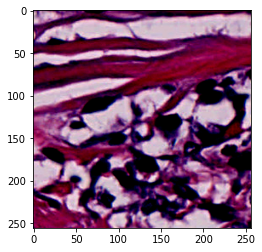

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([130, 3, 256, 256])


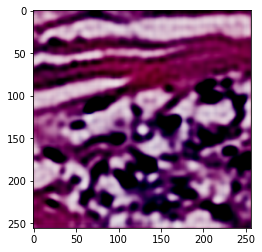

In [12]:
# check the output of decoder 
val_dataset = CustomTensorDataset(x)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size)
def print_result():
  model.eval()
  val_loss = []
  for _id,data in val_dataloader:
      with torch.no_grad():
          # ===================loading=====================
          if model_type in ['cnn', 'vae', 'resnet', 'unet']:
              img = data.float().cuda()
          elif model_type in ['fcn']:
              img = data.float().cuda()
              img = img.view(img.shape[0], -1)

          # ===================forward=====================
          output = model(img)
          return output,img
output_img,img=  print_result()
img.size()
out_id = 35
plt.imshow(  img[out_id].cpu().permute(1, 2, 0)  )
plt.show()
print(type(output_img),output_img.size())
plt.imshow(  output_img[out_id].cpu().permute(1, 2, 0)  )

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [13]:
eval_batch_size = 32

# load trained model
checkpoint_path = 'last_model2_cnn.pt'
model = torch.load(checkpoint_path)
model.eval()
torch.save(model.state_dict(), "best_parameter.pt")


In [14]:
#create a encoder to get the feature map of all test images
class conv_encoder(nn.Module):
    def __init__(self):
        super(conv_encoder, self).__init__()
        start_dim = 2
        self.encoder = nn.Sequential(
            nn.Conv2d(3, start_dim, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.Conv2d(start_dim, start_dim*2, 4, stride=2, padding=1),        
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.Conv2d(start_dim*2, start_dim*4, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.Conv2d(start_dim*4, start_dim*8, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.Conv2d(start_dim*8, start_dim*16, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*16),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(start_dim*16, start_dim*8, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.ConvTranspose2d(start_dim*8, start_dim*4, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.ConvTranspose2d(start_dim*4, start_dim*2, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.ConvTranspose2d(start_dim*2, start_dim, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.ConvTranspose2d(start_dim, 3, 4, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(3),
        )


    def forward(self, x):
        x = self.encoder(x)
        return x

encoder = conv_encoder() # Our encoder model
encoder.load_state_dict(torch.load('best_parameter.pt'))
device = "cuda"  # GPU device
encoder.to(device)


conv_encoder(
  (encoder): Sequential(
    (0): Conv2d(3, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kern

In [15]:
#create feature map of all test image
embedding_dim = (1, 32, 8, 8)
def create_embedding(encoder,  device='cuda'):
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    #print(embedding.size())
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, train_img in test_dataloader:
            #print(batch_idx)
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            embedding = torch.cat((embedding, enc_output), 0)
            print(batch_idx)
            #print(starembedding)
    # Return the embeddings
    return embedding[1:]
embedding = create_embedding(encoder)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

tensor([1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511,
        1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523,
        1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535,
        1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547,
        1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559,
        1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571,
        1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583,
        1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595,
        1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607,
        1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619,
        1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631,
        1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643,
        1644, 1645, 1646, 1647, 1648, 16

tensor([3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011,
        3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023,
        3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035,
        3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047,
        3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059,
        3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071,
        3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083,
        3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095,
        3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107,
        3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119,
        3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131,
        3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143,
        3144, 3145, 3146, 3147, 3148, 31

In [23]:
embed_array =  embedding.view(3427,-1).numpy()

In [57]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(embed_array)
pca_embed = pca.transform(embed_array)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.1460149  0.03495025 0.00398526 0.00371976 0.00320122 0.003135
 0.00273711 0.00268614 0.00263568 0.00254964]
[695.69885  340.3673   114.934616 111.0402   103.01022  101.9392
  95.2508    94.35973   93.46938   91.93109 ]


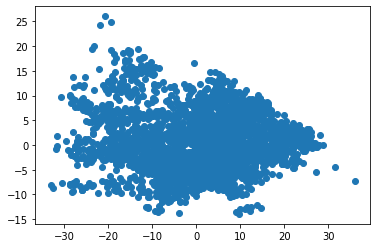

In [58]:
plt.scatter(pca_embed[:,0],pca_embed[:,1])

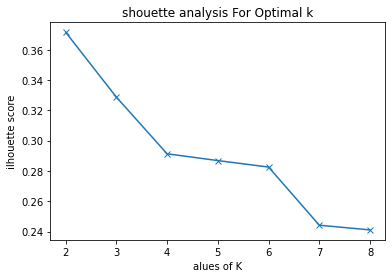

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,]
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(pca_embed)
  cluster_labels = kmeans.labels_
 # silhouette score
  silhouette_avg.append(silhouette_score(pca_embed, cluster_labels))
  
plt.plot(range_n_clusters,silhouette_avg,'x-')
plt.xlabel('alues of K') 
plt.ylabel('ilhouette score')
plt.title('shouette analysis For Optimal k')
plt.show()

C:\Users\alwaysmle\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


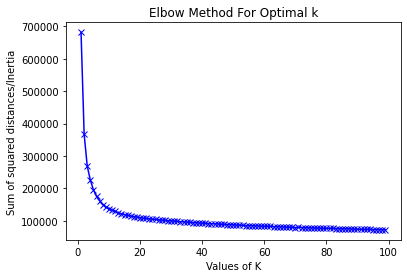

In [74]:
Sum_of_squared_distances = []
K = range(1,100)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(pca_embed)
  Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [82]:
from sklearn import cluster, datasets
# KMeans 演算法
kmeans_fit = cluster.KMeans(n_clusters = 5).fit(pca_embed)

# 印出分群結果
cluster_labels = kmeans_fit.labels_
print("分群結果：")
print(cluster_labels)
print("---")
cluster_labels.shape



分群結果：
[4 3 1 ... 4 2 4]
---


(3427,)

In [79]:
#get similarity of two query
import csv
def getSimilarityMatrix(a1,a2):
    cos_sim = np.dot(a1,a2) / (np.linalg.norm(a1) * np.linalg.norm(a2))
    return cos_sim
query_csv_file = pd.read_csv(query_csv,header=None)
sim_arr = []
id_1 = []
id_2 = []
for i in query_csv_file.values:
  img1 = i[0][:-4]
  img2 = i[1][:-4]
  img1_id = np.where(img1==test_id)
  img2_id = np.where(img2==test_id)
  sim_arr.append(getSimilarityMatrix(embedding[img1_id].flatten(),embedding[img2_id].flatten()))
  id_1.append(img1_id)
  id_2.append(img2_id)

In [86]:
#use k mean
sim_output=sim_arr.copy()
for i in range(len(sim_output)):
  if(cluster_labels[id_1[i]]==cluster_labels[id_2[i]]):
    sim_output[i] = 1
  else:
    sim_output[i] = 0

In [106]:
#get similarity of all img in test to random 200 images
similar_arr = []
count = 0
for i in range(len(embedding)):
  temp = []
  for j in np.random.randint(3427, size=200):
    temp.append(getSimilarityMatrix(embedding[i].flatten(),embedding[j].flatten()))
  similar_arr.append(np.quantile(temp, 0.8))

In [114]:
#if similarity is larger than 0.8 of random images , output 1
sim_output=sim_arr.copy()
#median = np.quantile(sim_arr, 0.75)
for i in range(len(sim_output)):
  if(sim_output[i]>(similar_arr[id_1[i][0][0]]+similar_arr[id_2[i][0][0]])/2):
    sim_output[i] = 1
  else:
    sim_output[i] = 0

In [25]:
#if similarity is larger median
sim_output=sim_arr.copy()
median = np.quantile(sim_arr,0.61209)
print(median)
for i in range(len(sim_output)):
  if(sim_output[i]>median):
    sim_output[i] = 1
  else:
    sim_output[i] = 0

0.26537773309886453


In [26]:
#if similarity is larger 0.5
sim_output=sim_arr.copy()
median = 0.5
print(median)
for i in range(len(sim_output)):
  if(sim_output[i]>median):
    sim_output[i] = 1
  else:
    sim_output[i] = 0

0.5


In [87]:
import csv
csv_name = 'kmean5.csv'
count = 0
with open(csv_name, 'w', newline='') as result:
  writer = csv.writer(result)
  writer.writerow(['query', 'prediction'])
  for i in query_csv_file.values:
    writer.writerow([i[0][:-4]+'_'+i[1][:-4], sim_output[count]])
    count+=1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702


7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250


11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
1127

15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15485
15486
15487
1548

18894
18895
18896
18897
18898
18899
18900
18901
18902
18903
18904
18905
18906
18907
18908
18909
18910
18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
1906

22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
2312

26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
26362
26363
26364
26365
26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376
26377
26378
26379
26380
26381
26382
26383
26384
26385
26386
26387
26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414
26415
26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428
26429
26430
26431
26432
26433
26434
26435
26436
26437
26438
26439
26440
26441
26442
26443
26444
26445
26446
26447
26448
26449
26450
26451
26452
26453
26454
26455
26456
26457
26458
26459
26460
26461
26462
26463
26464
26465
26466
26467
26468
26469
26470
26471
26472
26473
26474
26475
26476
26477
26478
26479
26480
26481
26482
26483
26484
26485
26486
2648

30320
30321
30322
30323
30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349
30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30363
30364
30365
30366
30367
30368
30369
30370
30371
30372
30373
30374
30375
30376
30377
30378
30379
30380
30381
30382
30383
30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405
30406
30407
30408
30409
30410
30411
30412
30413
30414
30415
30416
30417
30418
30419
30420
30421
30422
30423
30424
30425
30426
30427
30428
30429
30430
30431
30432
30433
30434
30435
30436
30437
30438
30439
30440
30441
30442
30443
30444
30445
30446
30447
30448
30449
30450
30451
30452
30453
30454
30455
30456
30457
30458
30459
30460
30461
30462
30463
30464
30465
30466
30467
30468
30469
30470
30471
30472
30473
30474
30475
30476
30477
30478
30479
30480
30481
30482
30483
30484
30485
3048

33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
33714
33715
33716
33717
33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
33750
33751
33752
33753
33754
33755
33756
33757
33758
33759
33760
33761
33762
33763
33764
33765
33766
33767
33768
33769
33770
33771
33772
33773
33774
33775
33776
33777
33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
33789
33790
33791
33792
33793
33794
33795
33796
33797
33798
33799
33800
33801
33802
33803
33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814
33815
33816
33817
33818
33819
33820
33821
33822
33823
33824
33825
33826
33827
33828
33829
33830
33831
33832
33833
33834
33835
33836
33837
33838
33839
33840
33841
33842
33843
33844
33845
33846
33847
33848
33849
33850
33851
33852
33853
33854
33855
33856
33857
33858
33859
33860
33861
33862
33863
33864
33865
3386

37820
37821
37822
37823
37824
37825
37826
37827
37828
37829
37830
37831
37832
37833
37834
37835
37836
37837
37838
37839
37840
37841
37842
37843
37844
37845
37846
37847
37848
37849
37850
37851
37852
37853
37854
37855
37856
37857
37858
37859
37860
37861
37862
37863
37864
37865
37866
37867
37868
37869
37870
37871
37872
37873
37874
37875
37876
37877
37878
37879
37880
37881
37882
37883
37884
37885
37886
37887
37888
37889
37890
37891
37892
37893
37894
37895
37896
37897
37898
37899
37900
37901
37902
37903
37904
37905
37906
37907
37908
37909
37910
37911
37912
37913
37914
37915
37916
37917
37918
37919
37920
37921
37922
37923
37924
37925
37926
37927
37928
37929
37930
37931
37932
37933
37934
37935
37936
37937
37938
37939
37940
37941
37942
37943
37944
37945
37946
37947
37948
37949
37950
37951
37952
37953
37954
37955
37956
37957
37958
37959
37960
37961
37962
37963
37964
37965
37966
37967
37968
37969
37970
37971
37972
37973
37974
37975
37976
37977
37978
37979
37980
37981
37982
37983
37984
37985
3798

42274
42275
42276
42277
42278
42279
42280
42281
42282
42283
42284
42285
42286
42287
42288
42289
42290
42291
42292
42293
42294
42295
42296
42297
42298
42299
42300
42301
42302
42303
42304
42305
42306
42307
42308
42309
42310
42311
42312
42313
42314
42315
42316
42317
42318
42319
42320
42321
42322
42323
42324
42325
42326
42327
42328
42329
42330
42331
42332
42333
42334
42335
42336
42337
42338
42339
42340
42341
42342
42343
42344
42345
42346
42347
42348
42349
42350
42351
42352
42353
42354
42355
42356
42357
42358
42359
42360
42361
42362
42363
42364
42365
42366
42367
42368
42369
42370
42371
42372
42373
42374
42375
42376
42377
42378
42379
42380
42381
42382
42383
42384
42385
42386
42387
42388
42389
42390
42391
42392
42393
42394
42395
42396
42397
42398
42399
42400
42401
42402
42403
42404
42405
42406
42407
42408
42409
42410
42411
42412
42413
42414
42415
42416
42417
42418
42419
42420
42421
42422
42423
42424
42425
42426
42427
42428
42429
42430
42431
42432
42433
42434
42435
42436
42437
42438
42439
4244

46318
46319
46320
46321
46322
46323
46324
46325
46326
46327
46328
46329
46330
46331
46332
46333
46334
46335
46336
46337
46338
46339
46340
46341
46342
46343
46344
46345
46346
46347
46348
46349
46350
46351
46352
46353
46354
46355
46356
46357
46358
46359
46360
46361
46362
46363
46364
46365
46366
46367
46368
46369
46370
46371
46372
46373
46374
46375
46376
46377
46378
46379
46380
46381
46382
46383
46384
46385
46386
46387
46388
46389
46390
46391
46392
46393
46394
46395
46396
46397
46398
46399
46400
46401
46402
46403
46404
46405
46406
46407
46408
46409
46410
46411
46412
46413
46414
46415
46416
46417
46418
46419
46420
46421
46422
46423
46424
46425
46426
46427
46428
46429
46430
46431
46432
46433
46434
46435
46436
46437
46438
46439
46440
46441
46442
46443
46444
46445
46446
46447
46448
46449
46450
46451
46452
46453
46454
46455
46456
46457
46458
46459
46460
46461
46462
46463
46464
46465
46466
46467
46468
46469
46470
46471
46472
46473
46474
46475
46476
46477
46478
46479
46480
46481
46482
46483
4648